<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 4 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Campbell Gregor
- <b>Student ID:</b> 33110018  

<div class="alert alert-block alert-danger">

## Table of Contents

* [Libraries](#Libraries)
    
* [Task 4.1: Create dataloaders and visualize the dataset](#t5_1)
    
* [Task 4.2: Load and Apply Transfer Learning with Pre-trained Model](#t5_2)
    
* [Task 4.3: Train and Test the model](#t5_3)
    
* [Task 4.4: Visualise predicted landmarks for some of the images](#t5_4)
    
* [Task 4.5: Discussion Questions](#t5_5)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [91]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [92]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data.dataset import Dataset
from torchmetrics import MeanSquaredError

import pytorch_lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 64 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 ## Set to your device

Seed set to 4179


<div class="alert alert-block alert-info">

# Face Landmarks Detection with Transfer Learning
    
## What you should do in this task!

In this task you will be applying transfer learning on a ResNet50 model for the Face Landmark Detection task using Pytorch and PyTorch Lightning.

You have to use Pytorch inbuilt models to load the ResNet50 model and its pre-trained parameters, then use the Pytorch Lightning module class to modify the ResNet50 model architecture in order to detect landmarks of human faces. As always, we will train our model using stochastic gradient descent (SGD).

#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders with suggested transformations.
 2. Visualise a training sample with ground truth landmark points.
 3. Modify the ResNet50 model.
 4. Perform training and evaluation of the model.
 5. Visualise your experimental results.
    
<img src="figures/face_landmarks.png" width="700" align="center">

<div class="alert alert-block alert-info">
    
### Task 4.1: Create dataloaders and visualize the dataset <a class="anchor" id="t5_1"></a>
    
In this section you have to create dataloaders for the face landmarks dataset. To do so, begin by crafting a Dataset class called **FLD_Data** to read data from **face_landmark.npz**. Then, visualise a few samples of the data along with the landmarks.

The FLD data can be loaded in completely since it is relatively small.

Have a look at how the data is loaded in to understand how to access the data for the modelling process. You do NOT have to edit the FLD_Data class!

In [93]:
class FLD_Data(Dataset):
    def __init__(self, trn_tst = 0, transform=None):
        # Load numpy data
        data = np.load(PATH_DATASETS + '/face_landmark.npz')
        if trn_tst == 0:
            # Create dataset for trainloader 
            self.images = data['train_images']
            self.landmarks = data['train_landmarks']
        else:
            # Create dataset for testloader 
            self.images = data['test_images']
            self.landmarks = data['test_landmarks']
            
        self.transform = transform   ## Save the transforms as your class' attributes

    # Define len function
    def __len__(self):
        return len(self.images)

    # Define getitem function
    def __getitem__(self, idx):

        image = self.images[idx]
        landmarks = self.landmarks[idx]
        
        if self.transform is not None:  ## If there is a transform, apply it here to your sample
            image = self.transform(image)
            
        return image, torch.from_numpy(landmarks).float() ## Useful for your loss later on

In [94]:
# Define a series of image transformations to be applied to data
data_transforms = transforms.Compose([
    transforms.ToTensor(),     # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),     # Normalize pixel values to have a mean and standard deviation of 0.5
])

#test  = np.load(PATH_DATASETS + '/face_landmark.npz')
#print(test)

In [95]:
## Set your train and test datasets
train_dataset = FLD_Data(trn_tst=0, transform=data_transforms)
test_dataset = FLD_Data(trn_tst=1, transform=data_transforms)

Using the 'random_split' function, create a validation dataset by using 10% of training data.

In [96]:
# split the dataset into validation and test sets
# use 10% data as validation data from training data
len_valid_set = int(0.1*len(train_dataset)) ## 10% of the data data
len_train_set = len(train_dataset) - len_valid_set  ## 90% of the remaining train data

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])  ## Split train data

# shuffle relevant datasets and use the torch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# You can print the length of the train, validation, and test set to ensure they are correct
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len(test_dataset)))

The length of Train set is 694
The length of Valid set is 77
The length of Test set is 221


In [97]:
# Write visualize_dataloader function to visualize 3 images from a given data loader

# Define a function to visualize images from a data loader
# Input parameters: dataloader 
def visualize_dataloader(dataloader):

    # Create a figure with subplots to display images
    fig, axes = plt.subplots(1, 3)

    # Get a batch of images and labels from the data loader
    images, landmarks = next(iter(dataloader))

    # Loop through the first 3 images in the batch
    for i in range(3):

        # Un-normalize the image
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5 

        # Display the image with the landmarks (labels) in the subplot
        axes[i].imshow(img)
        axes[i].scatter(landmarks[i][:,0], landmarks[i][:,1], c='r', s=3)
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    # Show the plot
    plt.show()

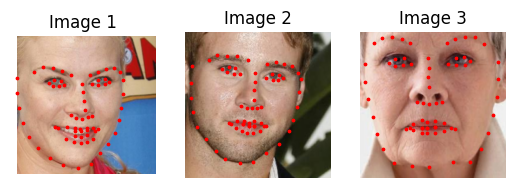

In [98]:
# Visualise 3 images as well as their corresponding facial landmarks from the test_loader

visualize_dataloader(test_loader)

#images, landmarks = next(iter(test_loader))
#print("Landmark shape:", landmarks.shape)
#print("First few landmarks:")
#print(landmarks[0][:10])


<div class="alert alert-block alert-info">
    
### Task 4.2: Load and Apply Transfer Learning with Pre-trained Base Model <a class="anchor" id="t5_2"></a>

Transfer learning can be employed when the goal is to use pre-trained models for a new task. The new task can be classification or numerical estimation, but the important thing about transfer learning is that you need to ensure the dataset used for the pre-training is similar in its distribution to the new task. For example, if you pre-trained model was only trained on classifcation of coloured images, it will not perform well for black and white images! 

In this task you need to:
- Load in a **resnet50** model **WITH** pretrained weights and print model structure of resnet50
- Replace the current FC layer in the **resnet50** model with a new FC layer 


In [99]:
from torchvision.models import resnet50, ResNet50_Weights

# Load the model using torchvision and print the model structure
model = resnet50(weights=ResNet50_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [100]:
class FaceLandmarkDetection(pl.LightningModule):
    def __init__(self, learning_rate=0.001, num_classes=136):
        super().__init__()
        self.learning_rate = learning_rate 
        self.loss_fun = nn.MSELoss()  ## Define your loss! What should it be?
        
        ## Load the pre-trained network as follows
        ## Use the importedweights of:   ResNet50_Weights.IMAGENET1K_V1
        ## See pytorch documentation on how to load models with a pre-trained weight
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model = self.model.float()  # Convert model parameters to float32, getting float error
        ## Freeze the model weights (see PDF's hints)
        ## You can set the param.requires_grad = False 
        ## That way those parameters will not get updated
        for param in self.model.parameters():
            param.requires_grad = False

        ## Remake the FC layer. You can use the in_features from the original model 
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        ## Which error do we use? Remember, we are dealing with minimising coordinate errors in the landmarks
        ## This should be the same as your loss function
        self.val_error = MeanSquaredError()
        self.train_error = MeanSquaredError()
        self.test_error = MeanSquaredError()
            
    def forward(self, x):
        #Pass input through conv layers
        # Equiv to passing through RES50 and new lin layer???
        x = x.float()  # Convert input to float32 get error otherwise
        x_out = self.model(x)
    
        return x_out
    
    def training_step(self, batch, batch_idx):
        ## Obtain predictions
        x, y = batch
        preds = self(x)
        
        y = y.view(y.size(0), -1) 
        loss = self.loss_fun(preds, y)
        error = self.train_error(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_error", error, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        
        y = y.view(y.size(0), -1)
        loss = self.loss_fun(preds, y)
        error = self.val_error(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_error", error, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        y = y.view(y.size(0), -1) 
        loss = self.loss_fun(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        
        return (pred, y, x)   ## Return 3 values here: predicted landmarks, original landmarks and the original image

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
### Task 4.3: Train and Test the model <a class="anchor" id="t5_3"></a>

In [102]:
## Initialise your face landmark model
## Train until the end of max_epochs or if the early stopping condition has occured
## Note that if you implement it similarly to how we have done it (same hyper parameters etc.)
## Then your epoch should stop around ~110 (+/- 25 epochs)

FaceLandmarkDetection_model = FaceLandmarkDetection()

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_task_4/",
        save_top_k=1,        # save the best model
        mode="min",
        every_n_epochs=1
    )

# Train and test the model
trainer = pl.Trainer(
    accelerator="auto",
    #devices=1 if torch.cuda.is_available() else None,  
    max_epochs=50,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback],
    logger=CSVLogger(save_dir="logs_task_4/"),
)
trainer.fit(FaceLandmarkDetection_model)
trainer.test()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | loss_fun    | MSELoss          | 0      | train
1 | model       | ResNet           | 23.8 M | train
2 | val_error   | MeanSquaredError | 0      | train
3 | train_error | MeanSquaredError | 0      | train
4 | test_error  | MeanSquaredError | 0      | train
---------------------------------------------------------
278 K     Trainable params
23.5 M    Non-trainable params
23.8 M    Total params
95.147    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at C:\Users\cgreg\Documents\Uni\ECE4179\ECE4179_Assignment_2024\checkpoints_task_4\epoch=49-step=550.ckpt
Loaded model weights from the checkpoint at C:\Users\cgreg\Documents\Uni\ECE4179\ECE4179_Assignment_2024\checkpoints_task_4\epoch=49-step=550.ckpt
c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_w

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            282.9244079589844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 282.9244079589844}]

Obtain a MSE loss of less than 650 on the validation set in less than 100 epochs.

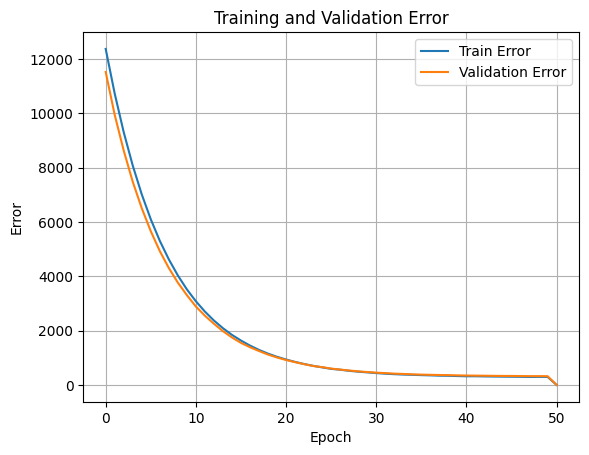

In [103]:
## Plot your train and validation losses!

# read logs 
metrics_task = pd.read_csv(trainer.logger.log_dir + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

# Plot using matplotlib to plot your results
plt.figure()
plt.plot(metrics_task.index, metrics_task['train_error'], label='Train Error')
plt.plot(metrics_task.index, metrics_task['val_error'], label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Error')
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
    
### Task 4.4: Visualise predicted landmarks for some of the images <a class="anchor" id="t5_4"></a>
    
Utilise the trainer predict method to output the predicted landmarks. Then overlay this with the original landmarks and the original image.

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

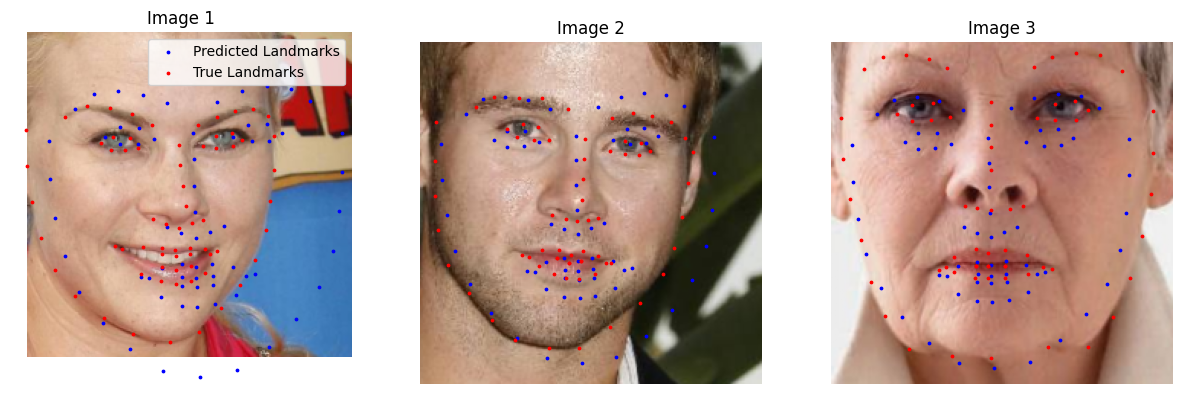

In [111]:
## Scatter plot for model trained using SGD
# Get the images, labels, and predictions
predictions = trainer.predict(FaceLandmarkDetection_model, test_loader)

pred_landmarks, true_landmarks, images = zip(*predictions)

pred_landmarks = torch.cat(pred_landmarks)
true_landmarks = torch.cat(true_landmarks)
images = images = torch.cat(images)
# Create a subplot with 1 row and 3 columns to display images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate through the first 3 samples for visualization

for i in range(3): 
    ax = axes[i]
    # Un-normalize the image
    img = images[i].permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5
    
    ax.imshow(img.astype('uint8'))
    axes[i].imshow(img)

    pred_landmarks_reshaped = pred_landmarks[i].view(-1, 2)
    true_landmarks_reshaped = true_landmarks[i].view(-1, 2)

    axes[i].scatter(pred_landmarks_reshaped[:,0], pred_landmarks_reshaped[:,1], c='b', s=3, label='Predicted Landmarks')
    axes[i].scatter(true_landmarks_reshaped[:,0], true_landmarks_reshaped[:,1], c='r', s=3, label='True Landmarks')
    
    if i == 0:
        ax.legend()
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')


# Show the plotted images
plt.show()

<div class="alert alert-block alert-success">
    
### Task 4.5: Discussion Questions <a class="anchor" id="t5_5"></a>

### Questions
1. What are two things to keep in mind about the data when choosing your pre-trained model? Why are these important? 

3. What was your thought process in finetuning your model to achieve the required test loss?
    
### Answers
    
1. The data needs to be similar to the original data that the loaded model was trained on:
- For instance, a model pre-trained on a broad image classification task like ImageNet might be less optimal than one trained on faces or human-related tasks. 
- The closer the original training data is to the target data, the better the pre-trained features will align with your task, reducing the amount of fine-tuning needed and potentially leading to better performance.
The new data size and shape needs to be the same as what the loaded model ws trained on or must be altered to fit it:
- Pre-trained models often expect inputs of a certain size. If the input data deviates from this it will need to be resized or additional layers need to be added
- Most pre-trained models are designed for three-channel inputs but some images like grayscale with one channel or hyperspectral images have more. The model will either need to adjust your data to fit the model's expected input shape or modify the model's first layer to accept a different number of input channels

2. Initially, I thought I would run a baseline model with minimal changes to the model so I just replaced the final layer with one that would fit the output. I also decided on the MSE loss as it made sense since I was working with spatial points. This gave a test loss of 282.9 which I did not think I would achieve on the first go. As seen in the visualisation, it is not perfect by any means so I to improve it I would add more layers on top of the frozen ones.
